In [1]:
from cellpose import models, io
from cellpose.io import *
from collections import defaultdict
import geopandas
import glob
import imagej
from jpype import JArray, JInt
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import shutil
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import sys
import os
from zipfile import ZipFile
import csv
import random
from math import isnan 

In [2]:
root = tk.Tk()
root.withdraw()
dataset = filedialog.askopenfilename()
df = pandas.read_csv(dataset)

In [3]:
df.head()

,Unnamed: 0,circle,Experiment-1546_321,Experiment-1546_86,Experiment-1546_71,Experiment-1546_4,Experiment-1546_290,Experiment-1546_301,Experiment-1546_105,Experiment-1546_140,...,Experiment-1547_150,Experiment-1547_52,Experiment-1547_7,Experiment-1547_67,Experiment-1547_318,Experiment-1547_30,Experiment-1547_47,Experiment-1547_55,Experiment-1547_233,Experiment-1547_134
0,0,1,90.722255,16.427105,28.095238,7.082153,107.715134,20.209974,33.000000,5.757576,...,46.540881,12.138728,14.858491,42.059337,17.834395,26.328904,13.586957,84.265734,22.659176,463.907285
1,1,2,64.695144,13.169985,5.370844,6.486486,47.796935,13.611615,32.690355,5.315615,...,114.885194,3.391813,2.731788,43.978244,24.399038,5.328377,2.601457,28.186715,7.443609,317.145594
2,2,3,56.265443,13.342697,4.210526,8.701657,44.962531,12.311358,29.772329,4.360902,...,173.787111,2.667984,3.223443,48.816156,24.064712,3.195266,2.951699,17.387884,7.128447,252.955870
3,3,4,58.579681,15.083440,4.640215,8.411215,48.306333,9.180791,32.717475,3.331067,...,237.549148,3.250642,4.007884,41.095028,26.178010,2.518797,2.604578,14.355742,8.272506,190.648012
4,4,5,61.223822,16.949153,4.257908,7.832009,46.169089,9.917355,31.524725,2.401478,...,283.025610,2.639517,4.050030,39.518900,23.407521,2.677615,2.612994,13.438486,9.772349,141.809775


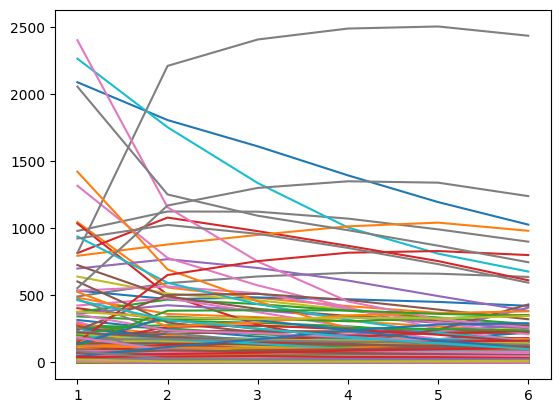

In [5]:
for i in range (2, len(df.columns)):
    plt.plot(df['circle'], df[df.columns[i]])

result = f"/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/plot_gal3.tif"
plt.savefig(result)

In [ ]:
result = Path(f"/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/plot_gal3.svg")
plt.savefig(result)

In [4]:
df_transposed = df.transpose()

In [5]:
df_transposed.head()

,0,1,2,3,4,5
Unnamed: 0,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
circle,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000
Experiment-1546_321,90.722255,64.695144,56.265443,58.579681,61.223822,60.640301
Experiment-1546_86,16.427105,13.169985,13.342697,15.083440,16.949153,28.104925
Experiment-1546_71,28.095238,5.370844,4.210526,4.640215,4.257908,3.942254


In [6]:
df_cleaned = df_transposed.drop(["Unnamed: 0","circle"])
df_cleaned.rename(columns={df_cleaned.columns[0]: 'd0', 
                           df_cleaned.columns[1]: 'd1',  
                           df_cleaned.columns[2]: 'd2', 
                           df_cleaned.columns[3]: 'd3', 
                           df_cleaned.columns[4]: 'd4', 
                           df_cleaned.columns[5]: 'd5'}, inplace=True)
df_cleaned.head()

,d0,d1,d2,d3,d4,d5
Experiment-1546_321,90.722255,64.695144,56.265443,58.579681,61.223822,60.640301
Experiment-1546_86,16.427105,13.169985,13.342697,15.083440,16.949153,28.104925
Experiment-1546_71,28.095238,5.370844,4.210526,4.640215,4.257908,3.942254
Experiment-1546_4,7.082153,6.486486,8.701657,8.411215,7.832009,7.451798
Experiment-1546_290,107.715134,47.796935,44.962531,48.306333,46.169089,42.489527


In [7]:
df_norm = df_cleaned.sub(df_cleaned.mean(axis=1), axis=0)
df_norm.head()

,d0,d1,d2,d3,d4,d5
Experiment-1546_321,25.367814,-0.659297,-9.088998,-6.774760,-4.130619,-4.714140
Experiment-1546_86,-0.752446,-4.009566,-3.836854,-2.096110,-0.230398,10.925374
Experiment-1546_71,19.675741,-3.048654,-4.208971,-3.779282,-4.161590,-4.477243
Experiment-1546_4,-0.578733,-1.174400,1.040771,0.750328,0.171123,-0.209089
Experiment-1546_290,51.475209,-8.442990,-11.277393,-7.933592,-10.070836,-13.750397


In [54]:
df_melted = df_norm.melt(ignore_index=False)

In [55]:
df_melted.head()

,variable,value
Experiment-1546_321,d0,25.367814
Experiment-1546_86,d0,-0.752446
Experiment-1546_71,d0,19.675741
Experiment-1546_4,d0,-0.578733
Experiment-1546_290,d0,51.475209


In [8]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=10)

In [9]:
clustering.fit(df_norm)

AgglomerativeClustering(n_clusters=10)

In [10]:
experiment_labels = clustering.labels_

# Print the labels
print(experiment_labels)

[3 3 3 3 3 3 3 3 3 6 1 3 3 3 3 3 3 3 3 3 3 8 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 3 3 8 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 6 3 3 3 3 8 3 3 3 3 3 3 3 3 2 8 3 3 3 3 3 3 3 8 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 8 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 6 8 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 2 0 3 3 3 3 3 3 8 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 6 3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 8 3 3 9 3 3 3 3 3 3 3 3 2
 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 0 3 3 3
 3 3 3 3 3 8 3 0 3 3 0 3 3 3 3 3 3 3 6 3 1 3 3 3 3 3 3 3 3 3 3 3 3 8 3 3 3
 3 3 6 3 3 3 3 3 6 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 6 3 3 5 3 3 3 6 3 3 3 3 3 6 3 3 3 1 3 3 3 2 3 2 3 8 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3
 3 6 3 3 0 4 3 3 6 3 3 3 

In [11]:
df_norm['cluster'] = experiment_labels

In [12]:
df_norm.head()

,d0,d1,d2,d3,d4,d5,cluster
Experiment-1546_321,25.367814,-0.659297,-9.088998,-6.774760,-4.130619,-4.714140,3
Experiment-1546_86,-0.752446,-4.009566,-3.836854,-2.096110,-0.230398,10.925374,3
Experiment-1546_71,19.675741,-3.048654,-4.208971,-3.779282,-4.161590,-4.477243,3
Experiment-1546_4,-0.578733,-1.174400,1.040771,0.750328,0.171123,-0.209089,3
Experiment-1546_290,51.475209,-8.442990,-11.277393,-7.933592,-10.070836,-13.750397,3


In [ ]:
for cluster_num in df_norm['cluster'].unique():
    # Filter data for the current cluster
    cluster_data = df_norm[df_norm['cluster'] == cluster_num]
    
    # Plot the data for the current cluster
    plt.figure(figsize=(8, 6))
    for idx, row in cluster_data.iterrows():
        plt.plot(range(len(row)-1), row[:-1], label=idx)  # Exclude the last column 'cluster' from plotting
    plt.title(f'Cluster {cluster_num} Data')
    plt.xlabel('distance')
    plt.ylabel('Measurement')
    #plt.legend()
    plt.show()

In [17]:
image_list = []
cluster_num = 6
for i in range(len(df_norm)):
    if df_norm['cluster'][i] == cluster_num:
        image = df_norm.index[i]
        image_path = Path(f"/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement/{image}.tif").as_posix()
        image_list.append(image_path)

In [16]:
print(len(image_list))

610


In [14]:
import sys
import os
import glob
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtCore import *
from PyQt5.QtGui import *
from PyQt5.QtWidgets import *

In [18]:
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QScrollArea, QLabel, QGridLayout
from PyQt5.QtGui import QPixmap
from PyQt5.QtCore import Qt
import sys

class MainWindow(QMainWindow):

    def __init__(self, image_list):
        super().__init__()
        self.image_list = image_list
        self.window()
    
    def window(self):
        self.scroll = QScrollArea()
        self.win = QWidget()
        self.grid = QGridLayout()

        num_images = len(self.image_list)
        num_columns = 4  # Fixed number of columns
        num_rows = (num_images + num_columns - 1) // num_columns  # Calculate number of rows dynamically

        n = 0
        for i in range(num_rows):
            for j in range(num_columns):
                if n < num_images:
                    file = self.image_list[n]
                    pixmap = QPixmap(file)
                    pixmap2 = pixmap.scaled(500, 200, Qt.KeepAspectRatio)
                    label = QLabel(pixmap=pixmap2)
                    self.grid.addWidget(label, i, j)
                    n += 1
    
        self.win.setLayout(self.grid)
        self.scroll.setWidgetResizable(True)
        self.scroll.setVerticalScrollBarPolicy(Qt.ScrollBarAlwaysOn)
        self.scroll.setHorizontalScrollBarPolicy(Qt.ScrollBarAlwaysOn)
        self.scroll.setWidget(self.win)
        self.setCentralWidget(self.scroll)
        self.setGeometry(0, 0, 2300, 1000)
        self.setWindowTitle('Image Viewer')
        self.show()

def main():
    app = QApplication(sys.argv)
    main = MainWindow(image_list)
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()


SystemExit: 0

In [16]:
file_pattern = os.path.join("/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement", "*.tif")
file_list = glob.glob(file_pattern)

In [21]:
print(file_list)

['/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement\\Experiment-1546_1.tif', '/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement\\Experiment-1546_10.tif', '/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement\\Experiment-1546_105.tif', '/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement\\Experiment-1546_106.tif', '/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement\\Experiment-1546_107.tif', '/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement\\Experiment-1546_11.tif', '/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement\\Experiment-1546_113.tif', '/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement\\Experiment-1546_119.tif', '/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement\\Experiment-1546_126.tif', '/Users/MrWor/Documents/imaging/20230427 thp1lc3 gal3 alix/gal3/measurement\